**Deliverable 1**

Colab Notebook

In [ ]:
import pandas as pd
import numpy as np

from tqdm.auto import tqdm
from tqdm.notebook import tqdm, trange

import time
from time import sleep

import torch
from torchvision import datasets, transforms
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, TensorDataset
from torchvision.utils import make_grid
import cv2
import os
import pathlib
import imageio
from skimage.io import imread
from skimage.transform import resize
from skimage.color import rgb2gray
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import cv2
import glob
import seaborn as sns
import random
from sklearn.utils import resample

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device, torch.get_num_threads()

# DATA PREPARATION

In [2]:
## You have to install the Kaggle.json file from HW 4 for this notebook to work
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia
! unzip /content/chest-xray-pneumonia.zip

Streaming output truncated to the last 5000 lines.
  inflating: chest_xray/train/NORMAL/IM-0435-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0435-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0438-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0440-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0441-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0442-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0444-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0445-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0446-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0447-0001.jpeg  
  inflating:

In [ ]:
categories = ['NORMAL', 'PNEUMONIA']

In [ ]:
base_dir = "/content/chest_xray/"

train_pneumonia_dir = base_dir+'train/PNEUMONIA/'
train_normal_dir=base_dir+'train/NORMAL/'

test_pneumonia_dir = base_dir+'test/PNEUMONIA/'
test_normal_dir = base_dir+'test/NORMAL/'

val_pneumonia_dir= base_dir+'val/PNEUMONIA/'
val_normal_dir= base_dir+'val/NORMAL/'

train_pn = [train_pneumonia_dir+"{}".format(i) for i in os.listdir(train_pneumonia_dir) ]
train_normal = [train_normal_dir+"{}".format(i) for i in os.listdir(train_normal_dir) ]

test_normal = [test_normal_dir+"{}".format(i) for i in os.listdir(test_normal_dir)]
test_pn = [test_pneumonia_dir+"{}".format(i) for i in os.listdir(test_pneumonia_dir)]

val_pn= [val_pneumonia_dir+"{}".format(i) for i in os.listdir(val_pneumonia_dir) ]
val_normal= [val_normal_dir+"{}".format(i) for i in os.listdir(val_normal_dir) ]

print ("Total images:",len(train_pn+train_normal+test_normal+test_pn+val_pn+val_normal))
print ("Total Pneumonia images:",len(train_pn+test_pn+val_pn))
print ("Total Normal images:",len(train_normal+test_normal+val_normal))

Total images: 5856
Total Pneumonia images: 4273
Total Normal images: 1583


In [ ]:
pn = train_pn + test_pn + val_pn
normal = train_normal + test_normal + val_normal

In [ ]:
print(len(pn))
print(len(normal))

4273
1583


In [ ]:
train_imgs = pn[:3418]+ normal[:1224] 
test_imgs = pn[3418:4059]+ normal[1224:1502]
val_imgs = pn[4059:] + normal[1502:]

In [ ]:
import random

random.shuffle(train_imgs)
random.shuffle(test_imgs)
random.shuffle(val_imgs)


In [ ]:
import cv2
img_size = 224

In [ ]:
def preprocess_image(image_list):
    
    X = []
    y = [] 
    
    for image in image_list:

            img = cv2.imread(image,cv2.IMREAD_GRAYSCALE)    
            img=cv2.resize(img,(img_size,img_size),interpolation=cv2.INTER_CUBIC)
            img = np.dstack([img, img, img])
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = img.astype(np.float32)/255.
            img = img.flatten()

            X.append(img) 
            
            if 'NORMAL' in image:
                y.append(0)
            
            elif 'IM' in image:
                y.append(0)
            
            elif 'virus' or 'bacteria' in image:
                y.append(1)
            
    
    return X, y

In [ ]:
X_train, y_train = preprocess_image(train_imgs)

In [ ]:
X_train = np.asarray(X_train)
y_train = np.asarray(y_train)

In [ ]:
X_val, y_val = preprocess_image(val_imgs)

In [ ]:
X_val = np.asarray(X_val)
y_val = np.asarray(y_val)

In [ ]:
X_test, y_test = preprocess_image(test_imgs)

In [ ]:
X_test = np.asarray(X_test)
y_test = np.asarray(y_test)

# Exploratory Data Analysis 

In [ ]:
base_path = '/content/chest_xray'
train_path = os.path.join(base_path, 'train/')
test_path = os.path.join(base_path,'test/')
val_path = os.path.join(base_path, 'val/')

In [ ]:
#Creating dictionary for train dataset 
train_dataset_dict = {}
for (root, dirs, files) in os.walk(train_path):
  for dir in dirs:
    for files in os.walk((os.path.join(root, dir))):
      train_dataset_dict[dir] = len(files[2])

In [ ]:
train_dataset_dict

{'NORMAL': 1341, 'PNEUMONIA': 3875}

In [ ]:
#Creating dictionary for test dataset 
test_dataset_dict = {}
for (root, dirs, files) in os.walk(test_path):
  for dir in dirs:
    for files in os.walk((os.path.join(root, dir))):
      test_dataset_dict[dir] = len(files[2])

In [ ]:
test_dataset_dict

{'NORMAL': 234, 'PNEUMONIA': 390}

In [ ]:
#Creating dictionary for validation dataset 
val_dataset_dict = {}
for (root, dirs, files) in os.walk(val_path):
  for dir in dirs:
    for files in os.walk((os.path.join(root, dir))):
      val_dataset_dict[dir] = len(files[2])

In [ ]:
val_dataset_dict

{'NORMAL': 8, 'PNEUMONIA': 8}

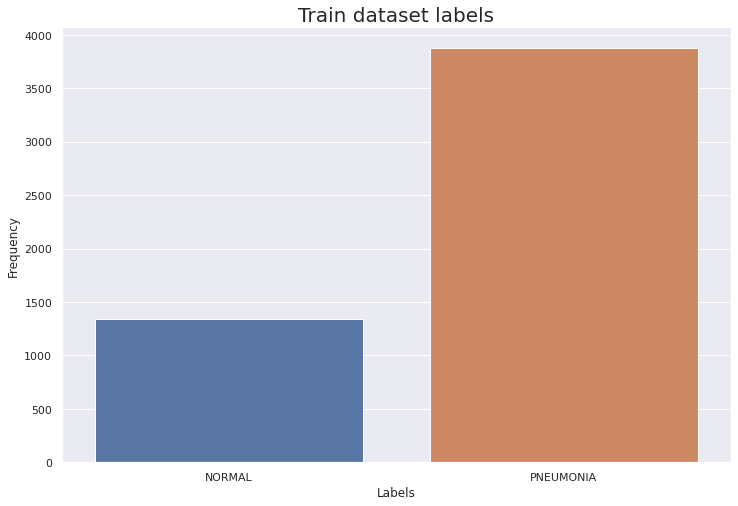

In [ ]:
#Creating barplot of train dataset  
sns.set(rc={'figure.figsize':(12,8)})
p = sns.barplot(x = list(train_dataset_dict.keys()), y = list(train_dataset_dict.values()))
p.set_xlabel('Labels', fontsize = 12)
p.set_ylabel('Frequency', fontsize = 12)
p.set_title('Train dataset labels', fontsize = 20);

In [ ]:
pneumonia = os.listdir('chest_xray/train/PNEUMONIA/')
pneumonia_dir = 'chest_xray/train/PNEUMONIA/'
normal = os.listdir('chest_xray/train/NORMAL/')
normal_dir = 'chest_xray/train/NORMAL/'

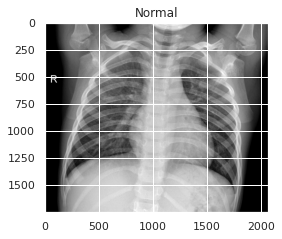

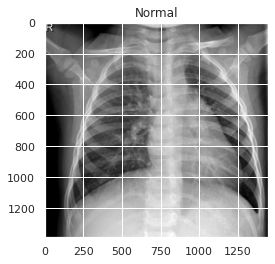

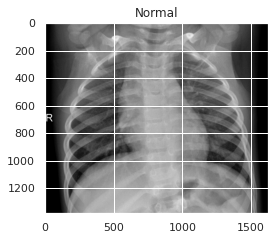

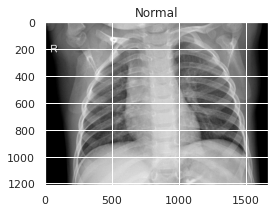

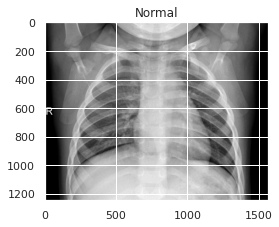

In [ ]:
#show normal xray images
sample_idxs = [0, 10, 20, 30, 40]
for id in sample_idxs:
  plt.figure(figsize = (4,4))
  image = plt.imread(os.path.join(normal_dir, normal[id]))
  plt.imshow(image, cmap = 'gray')
  plt.title('Normal')

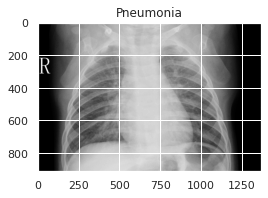

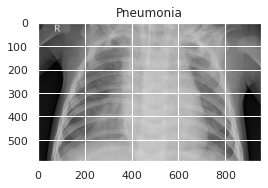

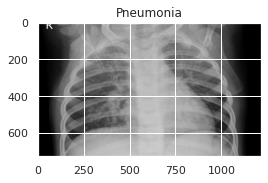

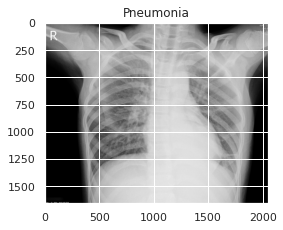

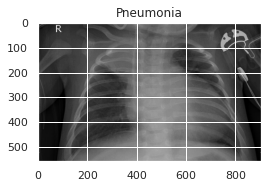

In [ ]:
#show pneumonia xray images
sample_idxs = [0, 10, 20, 30, 40]
for id in sample_idxs:
  plt.figure(figsize = (4,4))
  image = plt.imread(os.path.join(pneumonia_dir, pneumonia[id]))
  plt.imshow(image, cmap = 'gray')
  plt.title('Pneumonia')

# PCA

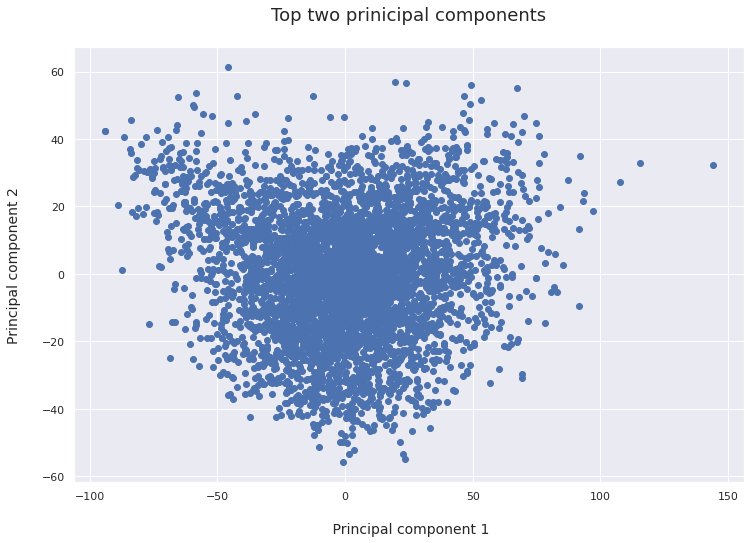

In [ ]:
#Visualize 2 components of PCA when applied to the training data
pca = PCA(n_components = 2)
x_train_pca = pca.fit_transform(X_train)
data = np.transpose(np.array(x_train_pca))

plt.figure(figsize=(12, 8))
plt.title('Top two prinicipal components\n', fontsize = 18)
plt.xlabel('\n Principal component 1', fontsize = 14)
plt.ylabel('Principal component 2\n', fontsize = 14);
plt.scatter(data[0][0:5000], data[1][0:5000])

In [ ]:
pca = PCA(n_components = 200)
x_train_pca = pca.fit_transform(X_train)

In [ ]:
explained_variance_ratios = pca.explained_variance_ratio_
cum_evr = np.cumsum(explained_variance_ratios)

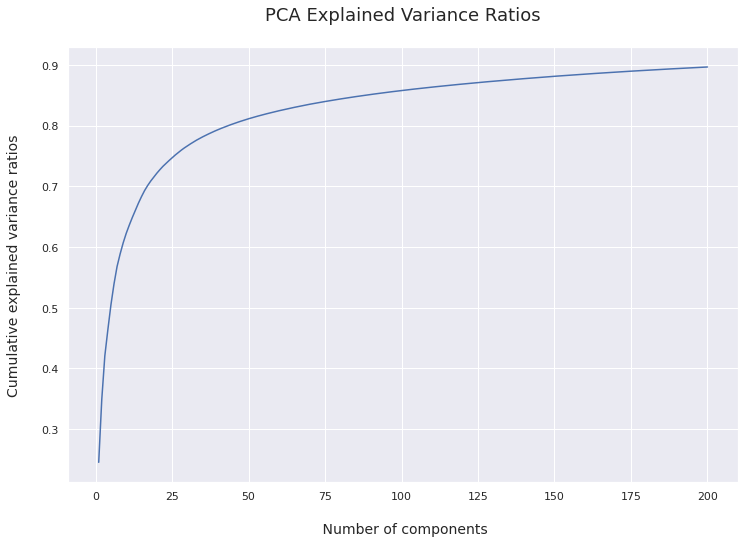

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(np.arange(1,201), cum_evr)
plt.title('PCA Explained Variance Ratios\n', fontsize = 18)
plt.xlabel('\n Number of components', fontsize = 14)
plt.ylabel('Cumulative explained variance ratios\n', fontsize = 14);

In [ ]:
#50 components explains 80% of total variance in dataset 
pca = PCA(n_components = 50)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

EVALUATION METRICS:
1.   Accuracy
2.   Recall
3.   Precision
4.   F1-Score
5.   Confusion Matrix

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score #weighted for imbalanced dataset
from sklearn.metrics import confusion_matrix
import seaborn as sns

#SUPERVISED MACHINE LEARNING TECHNIQUES

1.   Decision Trees
2.   Random Forest
3.   KNN
4.   Fully Connected Networks



## Decision Tree

In [ ]:
from sklearn import tree

In [ ]:
clf = tree.DecisionTreeClassifier()

In [ ]:
clf = clf.fit(X_train, y_train)

In [ ]:
y_pred = clf.predict(X_test)

In [ ]:
#Results
print("Accuracy is: ", accuracy_score(y_test, y_pred))
print("Balanced Accuracy is: ", balanced_accuracy_score(y_test, y_pred))
print("Recall is: ",recall_score(y_test, y_pred))
print("Precision is: ",precision_score(y_test, y_pred))
print("F1 Weighted Score is: ",f1_score(y_test, y_pred, average = 'weighted'))
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix: ", cm)
tn, fp, fn, tp = cm.ravel()
print("True Negative: ", tn, "False Positive: ", fp, "False Negative: ", fn, "True Positive: ", tp)

Accuracy is:  0.8487486398258978
Balanced Accuracy is:  0.7836114883444258
Recall is:  0.9485179407176287
Precision is:  0.8515406162464986
F1 Weighted Score is:  0.8413929702459794
Confusion Matrix:  [[172 106]
 [ 33 608]]
True Negative:  172 False Positive:  106 False Negative:  33 True Positive:  608


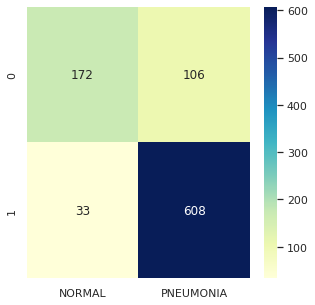

In [ ]:
confusion_matrix_df = pd.DataFrame(cm, columns = categories)
plt.subplots(figsize=(5,5))
ax = sns.heatmap(confusion_matrix_df,  annot=True,  fmt="d", cmap="YlGnBu")

## Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
clf = RandomForestClassifier(max_depth=2, random_state=0)

In [ ]:
clf.fit(X_train, y_train)

RandomForestClassifier(max_depth=2, random_state=0)

In [ ]:
y_pred = clf.predict(X_test)

In [ ]:
#Results
print("Accuracy is: ", accuracy_score(y_test, y_pred))
print("Balanced Accuracy is: ", balanced_accuracy_score(y_test, y_pred))
print("Recall is: ",recall_score(y_test, y_pred))
print("Precision is: ",precision_score(y_test, y_pred))
print("F1 Weighted Score is: ",f1_score(y_test, y_pred, average = 'weighted'))
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix: ", cm)
tn, fp, fn, tp = cm.ravel()
print("True Negative: ", tn, "False Positive: ", fp, "False Negative: ", fn, "True Positive: ", tp)

Accuracy is:  0.7018498367791077
Balanced Accuracy is:  0.5071942446043165
Recall is:  1.0
Precision is:  0.7005464480874317
F1 Weighted Score is:  0.5832548460129859
Confusion Matrix:  [[  4 274]
 [  0 641]]
True Negative:  4 False Positive:  274 False Negative:  0 True Positive:  641


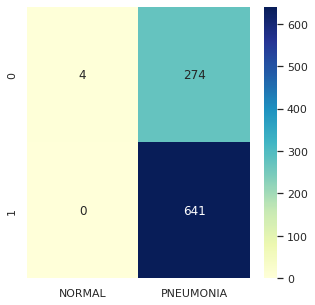

In [ ]:
confusion_matrix_df = pd.DataFrame(cm, columns = categories)
plt.subplots(figsize=(5,5))
ax = sns.heatmap(confusion_matrix_df,  annot=True,  fmt="d", cmap="YlGnBu")

## KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
knn_model = KNeighborsClassifier(n_neighbors = 10)
knn_model.fit(X_train,y_train)

KNeighborsClassifier(n_neighbors=10)

In [ ]:
y_pred = knn_model.predict(X_test)

In [ ]:
#Results
print("Accuracy is: ", accuracy_score(y_test, y_pred))
print("Balanced Accuracy is: ", balanced_accuracy_score(y_test, y_pred))
print("Recall is: ",recall_score(y_test, y_pred))
print("Precision is: ",precision_score(y_test, y_pred))
print("F1 Weighted Score is: ",f1_score(y_test, y_pred, average = 'weighted'))
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix: ", cm)
tn, fp, fn, tp = cm.ravel()
print("True Negative: ", tn, "False Positive: ", fp, "False Negative: ", fn, "True Positive: ", tp)

Accuracy is:  0.8726877040261154
Balanced Accuracy is:  0.8109574742701938
Recall is:  0.9672386895475819
Precision is:  0.8659217877094972
F1 Weighted Score is:  0.8662803193207343
Confusion Matrix:  [[182  96]
 [ 21 620]]
True Negative:  182 False Positive:  96 False Negative:  21 True Positive:  620


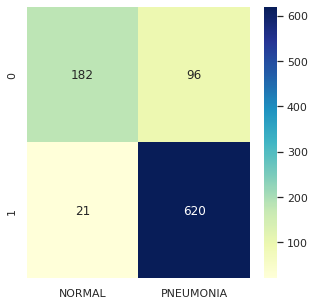

In [ ]:
confusion_matrix_df = pd.DataFrame(cm, columns = categories)
plt.subplots(figsize=(5,5))
ax = sns.heatmap(confusion_matrix_df,  annot=True,  fmt="d", cmap="YlGnBu")

## Fully Connected Networks

In [3]:
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import numpy as np
from PIL import Image

In [5]:
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.CenterCrop(224),
    transforms.RandomRotation(20),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [6]:
base_dir = "/content/chest_xray/"

train_dir = base_dir+'train/'

test_dir = base_dir+'test/'

val_dir= base_dir+'val/'

In [7]:
train_dataset = torchvision.datasets.ImageFolder(train_dir, transform=transform)
val_dataset = torchvision.datasets.ImageFolder(val_dir, transform=transform)
test_dataset = torchvision.datasets.ImageFolder(test_dir, transform=transform)

In [8]:
dataset_sizes = {"train" : len(train_dataset), "val": len(val_dataset), "test": len(test_dataset)}

In [9]:
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=256, num_workers = 2)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=256, num_workers = 2)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=256, num_workers = 2)

In [10]:
dataloaders = {"train": train_dataloader, "val":val_dataloader, "test":test_dataloader}

In [11]:
class FCN(nn.Module):
    def __init__(self):
        super(FCN, self).__init__()
        self.model = torchvision.models.resnet152(pretrained=True) #using pretrained ResNet model
        self.classifier = nn.Sequential(
        nn.Linear(self.model.fc.in_features,2), #binary classification
        nn.LogSoftmax(dim=1))
        for params in self.model.parameters():
            params.requires_grad = False #freezing the layers to make them non-trainable
        self.model.fc = self.classifier
    def forward(self, x):
        return self.model(x)

    def train_model(self, dataloaders, num_epochs):
        optimizer = optim.Adam(self.model.fc.parameters())
        criterion = nn.NLLLoss()
        best_acc = 0.0
        if torch.cuda.is_available():
            self.model = self.model.cuda()
        for epoch in range(num_epochs):
            print('Epoch: ', epoch)
            for phase in ['train', 'test']:
                if phase == 'train':
                    self.model.train() 
                else:
                    self.model.eval()
                running_loss = 0.0
                running_corrects = 0
                for inputs, labels in dataloaders[phase]:
                    if torch.cuda.is_available():
                        inputs = inputs.cuda()
                        labels = labels.cuda()
                    optimizer.zero_grad()
                    
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = self.model(inputs)
                        _, preds = torch.max(outputs, 1)

                        loss = criterion(outputs, labels)

                        if phase == 'train':
                            loss.backward()
                            optimizer.step()
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]
                print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                    phase, epoch_loss, epoch_acc))
        return self.model

In [12]:
fcn_model = FCN()

Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /root/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth


  0%|          | 0.00/230M [00:00<?, ?B/s]

In [13]:
#run 10 training epochs on our model
fcn_model_fit = fcn_model.train_model(dataloaders = dataloaders, num_epochs = 10)

Epoch:  0
train Loss: 1.3628 Acc: 0.6660
test Loss: 5.1108 Acc: 0.6250
Epoch:  1
train Loss: 2.8077 Acc: 0.7429
test Loss: 0.8275 Acc: 0.6250
Epoch:  2
train Loss: 0.9240 Acc: 0.4946
test Loss: 3.1143 Acc: 0.6250
Epoch:  3
train Loss: 1.9978 Acc: 0.6729
test Loss: 1.3512 Acc: 0.6250
Epoch:  4
train Loss: 1.1569 Acc: 0.4413
test Loss: 2.2535 Acc: 0.6250
Epoch:  5
train Loss: 1.6294 Acc: 0.5224
test Loss: 1.7182 Acc: 0.6250
Epoch:  6
train Loss: 1.3546 Acc: 0.4751
test Loss: 1.9294 Acc: 0.6250
Epoch:  7
train Loss: 1.4808 Acc: 0.4973
test Loss: 1.7852 Acc: 0.6250
Epoch:  8
train Loss: 1.4091 Acc: 0.4906
test Loss: 1.8454 Acc: 0.6250
Epoch:  9
train Loss: 1.4371 Acc: 0.4971
test Loss: 1.8067 Acc: 0.6250


# Addresing Class Imbalance by Upsampling or Downsampling

In [ ]:
def fix_class_imabalance(major_data, minor_data, strategy):
  if strategy == "upsample":
    upsampled_data = resample(minor_data, replace = True, n_samples = len(major_data), random_state = 42)
    return upsampled_data
  
  if strategy == "downsample":
    downsampled_data = resample(major_data, replace = True, n_samples = len(minor_data), random_state = 42)
    return downsampled_data

In [ ]:
pn_downsample = fix_class_imabalance(major_data = pn, minor_data = normal, strategy = "downsample")

In [ ]:
print(len(pn_downsample))

In [ ]:
normal_upsample = fix_class_imabalance(major_data = pn, minor_data = normal, strategy = "upsample")

In [ ]:
print(len(normal_upsample))

In [ ]:
train_imgs_down = pn_downsample[:1224]+ normal[:1224] 
test_imgs_down = pn_downsample[1224:1502]+ normal[1224:1502]
val_imgs_down = pn_downsample[1502:] + normal[1502:]

In [ ]:
train_imgs_up = normal_upsample[:3418]+ normal[:3418] 
test_imgs_up = normal_upsample[3418:4059]+ normal[3418:4059]
val_imgs_up = normal_upsample[4059:] + normal[4059:]

In [ ]:
import random
random.shuffle(train_imgs_down)
random.shuffle(test_imgs_down)
random.shuffle(val_imgs_down)
random.shuffle(train_imgs_up)
random.shuffle(test_imgs_up)
random.shuffle(val_imgs_up)
img_size = 224

In [ ]:
X_train_d, y_train_d = preprocess_image(train_imgs_down)
X_val_d, y_val_d = preprocess_image(val_imgs_down)
X_test_d, y_test_d = preprocess_image(test_imgs_down)
X_train_u, y_train_u = preprocess_image(train_imgs_up)
X_val_u, y_val_u = preprocess_image(val_imgs_up)
X_test_u, y_test_u = preprocess_image(test_imgs_up)

In [ ]:
X_train_d = np.asarray(X_train_d)
y_train_d = np.asarray(y_train_d)
X_val_d = np.asarray(X_val_d)
y_val_d = np.asarray(y_val_d)
X_test_d = np.asarray(X_test_d)
y_test_d = np.asarray(y_test_d)

In [ ]:
X_train_u = np.asarray(X_train_u)
y_train_u = np.asarray(y_train_u)
X_val_u = np.asarray(X_val_u)
y_val_u = np.asarray(y_val_u)
X_test_u = np.asarray(X_test_u)
y_test_u = np.asarray(y_test_u)

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
knn_model_down = KNeighborsClassifier(n_neighbors = 10)
knn_model_down.fit(X_train_d,y_train_d)
y_pred = knn_model_down.predict(X_test_d)
#Results
down_acc = accuracy_score(y_test_d, y_pred)
down_bal_acc = balanced_accuracy_score(y_test_d, y_pred)
down_recall = recall_score(y_test_d, y_pred)
down_precision = precision_score(y_test_d, y_pred)
down_f1 = f1_score(y_test_d, y_pred, average = 'weighted')
print("Accuracy is: ", down_acc)
print("Balanced Accuracy is: ", down_bal_acc)
print("Recall is: ",down_recall)
print("Precision is: ",down_precision)
print("F1 Weighted Score is: ",down_f1)
cm = confusion_matrix(y_test_d, y_pred)
print("Confusion Matrix: ", cm)
tn, fp, fn, tp = cm.ravel()
print("True Negative: ", tn, "False Positive: ", fp, "False Negative: ", fn, "True Positive: ", tp)
confusion_matrix_df = pd.DataFrame(cm, columns = categories)
plt.subplots(figsize=(5,5))
ax = sns.heatmap(confusion_matrix_df,  annot=True,  fmt="d", cmap="YlGnBu")

In [ ]:
knn_model_up = KNeighborsClassifier(n_neighbors = 10)
knn_model_up.fit(X_train_u,y_train_u)
y_pred = knn_model_up.predict(X_test_u)
#Results
up_acc = accuracy_score(y_test_u, y_pred)
up_bal_acc = balanced_accuracy_score(y_test_u, y_pred)
up_recall = recall_score(y_test_u, y_pred, zero_division=1)
up_precision = precision_score(y_test_u, y_pred, zero_division=1)
up_f1 = f1_score(y_test_u, y_pred, average = 'weighted')
print("Accuracy is: ", up_acc)
print("Balanced Accuracy is: ", up_bal_acc)
print("Recall is: ",up_recall)
print("Precision is: ",up_precision)
print("F1 Weighted Score is: ",up_f1)
cm = confusion_matrix(y_test_u, y_pred)
print("Confusion Matrix: ", cm)
if len(cm)==4:
  tn, fp, fn, tp = cm.ravel()
  print("True Negative: ", tn, "False Positive: ", fp, "False Negative: ", fn, "True Positive: ", tp)
  confusion_matrix_df = pd.DataFrame(cm, columns = categories)
  plt.subplots(figsize=(5,5))
  ax = sns.heatmap(confusion_matrix_df,  annot=True,  fmt="d", cmap="YlGnBu")

In [ ]:
labels = ['Accuracy', 'Balanced Accuracy', 'Recall', 'Precision', 'F1-Score']
down = [down_acc, down_bal_acc, down_recall, down_precision, down_f1]
up = [up_acc, up_bal_acc, up_recall, up_precision, up_f1]

In [ ]:
x = np.arange(len(labels))
width = 0.35

In [ ]:
fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, down, width, label='Downsampling')
rects2 = ax.bar(x + width/2, up, width, label='Upsampling')
ax.set_ylabel('Performance')
ax.set_title('Comparison of Sampling Strategies')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Hyperparameter Search using GridSearchCV

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

In [ ]:
clf = RandomForestClassifier(random_state=42)

In [ ]:
param_grid = { 
    'n_estimators': [50,100],
    'max_features': ['auto', 'sqrt'],
    'max_depth' : [4,8],
    'criterion' :['gini', 'entropy']
}

In [ ]:
rf_grid = GridSearchCV(estimator=clf, param_grid=param_grid, cv= 3,verbose=3)
rf_grid.fit(X_train, y_train)

In [ ]:
y_pred = rf_grid.predict(X_test)

In [ ]:
#Results
print("Accuracy is: ", accuracy_score(y_test, y_pred))
print("Balanced Accuracy is: ", balanced_accuracy_score(y_test, y_pred))
print("Recall is: ",recall_score(y_test, y_pred))
print("Precision is: ",precision_score(y_test, y_pred))
print("F1 Weighted Score is: ",f1_score(y_test, y_pred, average = 'weighted'))
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix: ", cm)
tn, fp, fn, tp = cm.ravel()
print("True Negative: ", tn, "False Positive: ", fp, "False Negative: ", fn, "True Positive: ", tp)

# CNN

In [ ]:
# Install dependencies 
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import os
import keras
import tensorflow
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout, BatchNormalization, MaxPooling2D, GlobalAveragePooling2D
from keras import backend as K
from tensorflow.keras.optimizers import Adam,RMSprop,SGD
from keras.applications.densenet import DenseNet121
from keras.preprocessing.image import ImageDataGenerator, load_img
from sklearn.metrics import classification_report, confusion_matrix, plot_roc_curve, roc_curve, auc, f1_score, precision_score, recall_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA,  IncrementalPCA

In [ ]:
cnn = Sequential()
cnn.add(Conv2D(filters=32, kernel_size=(3,3), activation="relu", padding="same",
                 input_shape=(64,64,1)))
cnn.add(BatchNormalization())
cnn.add(MaxPooling2D(pool_size=(2,2)))
cnn.add(Dropout(rate=0.3))
cnn.add(Conv2D(filters=64, kernel_size=(3,3), activation="relu", padding="same"))
cnn.add(BatchNormalization())
cnn.add(MaxPooling2D(pool_size=(2,2)))
cnn.add(Dropout(rate=0.3))
cnn.add(Flatten())
cnn.add(Dense(1024,activation="relu"))
cnn.add(BatchNormalization())
cnn.add(Dropout(rate=0.4))
cnn.add(Dense(2, activation="softmax"))
cnn.compile(Adam(lr=0.001), loss="categorical_crossentropy", metrics=["accuracy"])

In [ ]:
cnn.summary()

In [ ]:
train_clean = ImageDataGenerator()
size = (64,64)
training_data = train_clean.flow_from_directory('../content/chest_xray/train',
                                                 target_size = size,
                                                 color_mode="grayscale",
                                                 shuffle=True,
                                                 seed=42,
                                                 batch_size = 32)

validation_data = train_clean.flow_from_directory('../content/chest_xray/val/',
    target_size=size,
    color_mode="grayscale",
    shuffle=True,
    seed=42,
    batch_size=16)

test_data = train_clean.flow_from_directory('../content/chest_xray/test/',
    target_size=size,
    shuffle=False,
    color_mode="grayscale",
    batch_size=16)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [ ]:
cnn_model = cnn.fit(training_data,validation_data=validation_data,epochs=5)


In [ ]:
plt.figure(figsize=(12, 12))

plt.subplot(2, 2, 1)
plt.plot(cnn.history['loss'], label='Training Loss')
plt.plot(cnn.history['val_loss'], label='Validation Loss')
plt.title('Training Loss Progression')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.subplot(2, 2, 2)
plt.plot(cnn.history['accuracy'], label='Training Accuracy')
plt.plot(cnn.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training Accuracy Progression')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

In [ ]:
pred_cnn = cnn.predict(test_data)

In [ ]:
df_predict_cnn = pd.DataFrame(pred_cnn)
df_predict_cnn["file"] = test_data.filenames
df_predict_cnn[1] = (df_predict_cnn[1]-df_predict_cnn[1].mean())/df_predict_cnn[1].std() + 0.5
df_predict_cnn["true_value"] = (df_predict_cnn["file"].str.contains("PNEUMONIA")).apply(int)
df_predict_cnn['pred_value'] = (df_predict_cnn[1]>0.5).apply(int)
df_predict_cnn

,0,1,file,true_value,pred_value
0,0.919917,-1.573164,NORMAL/IM-0001-0001.jpeg,0,0
1,0.226501,0.414114,NORMAL/IM-0003-0001.jpeg,0,0
2,0.342536,0.081565,NORMAL/IM-0005-0001.jpeg,0,0
3,0.532916,-0.464047,NORMAL/IM-0006-0001.jpeg,0,0
4,0.936913,-1.621874,NORMAL/IM-0007-0001.jpeg,0,0
...,...,...,...,...,...
619,0.000137,1.062856,PNEUMONIA/person96_bacteria_465.jpeg,1,1
620,0.001666,1.058474,PNEUMONIA/person96_bacteria_466.jpeg,1,1
621,0.005002,1.048913,PNEUMONIA/person97_bacteria_468.jpeg,1,1
622,0.000689,1.061275,PNEUMONIA/person99_bacteria_473.jpeg,1,1


Text(0.5, 1.0, 'ROC Curve (auc = 0.910)')

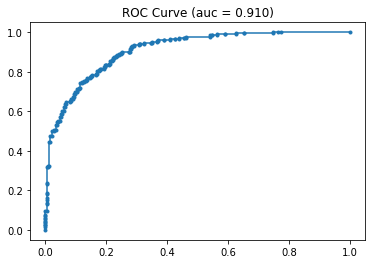

In [ ]:
cnn_fpr, cnn_trp, cnn_threshold = roc_curve(df_predict_cnn["true_value"], df_predict_cnn[1])
auc_cnn = auc(cnn_fpr, cnn_trp)
plt.plot(cnn_fpr, cnn_trp, marker='.')
plt.title(label='ROC Curve (auc = %0.3f)' % auc_cnn)

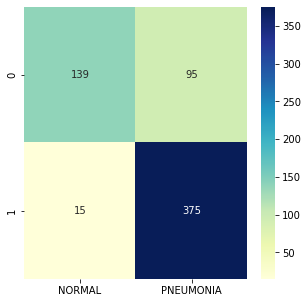

In [ ]:
confusion_matrix_cnn = pd.DataFrame(confusion_matrix(df_predict_cnn["true_value"], df_predict_cnn['pred_value']), columns = ['NORMAL', 'PNEUMONIA'])
plt.subplots(figsize=(5,5))
ax = sns.heatmap(confusion_matrix_cnn,  annot=True,  fmt="d", cmap="YlGnBu")

In [ ]:
print("AUC is: ", auc_cnn)
print("F1 Weighted Score is: ", f1_score(df_predict_cnn["true_value"], df_predict_cnn['pred_value'], average = "weighted"))

AUC is:  0.9101906640368178
F1 Weighted Score is:  0.813743706545193


In [ ]:
test_accuracy = (df_predict_cnn['true_value']==df_predict_cnn['pred_value']).astype(int).mean()
test_accuracy

0.8237179487179487

# Transfer Learning

In [ ]:
# Install dependencies 
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import os
import keras
import tensorflow
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout, BatchNormalization, MaxPooling2D, GlobalAveragePooling2D
from keras import backend as K
from tensorflow.keras.optimizers import Adam,RMSprop,SGD
from keras.applications.densenet import DenseNet121
from keras.preprocessing.image import ImageDataGenerator, load_img
from sklearn.metrics import classification_report, confusion_matrix, plot_roc_curve, roc_curve, auc, f1_score, precision_score, recall_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA,  IncrementalPCA

In [ ]:
base_densenet = DenseNet121(include_top=False, weights='imagenet')
pooling = GlobalAveragePooling2D()(base_densenet.output)
predictions = Dense(2, activation="softmax")(pooling)
densenet = Model(inputs=base_densenet.input, outputs=predictions)
densenet.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

In [ ]:
clean = ImageDataGenerator()
size = (180,180)
training_data = clean.flow_from_directory('../content/chest_xray/train',
                                                 target_size = size,
                                                 shuffle=True,
                                                 seed=42,
                                                 batch_size = 32)

validation_data = clean.flow_from_directory('../content/chest_xray/val/',
    target_size=size,
    shuffle=True,
    seed=42,
    batch_size=16)

test_data = clean.flow_from_directory('../content/chest_xray/test/',
    target_size=size,
    shuffle=False,
    batch_size=16)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [ ]:
densenet_model = densenet.fit(training_data, epochs=5,
                              validation_data=validation_data)


Epoch 1/7
163/163 [==============================] - 111s 566ms/step - loss: 0.1238 - accuracy: 0.9559 - val_loss: 0.5669 - val_accuracy: 0.8125
Epoch 2/7
163/163 [==============================] - 88s 535ms/step - loss: 0.0866 - accuracy: 0.9701 - val_loss: 0.2069 - val_accuracy: 0.8750
Epoch 3/7
163/163 [==============================] - 88s 536ms/step - loss: 0.0539 - accuracy: 0.9803 - val_loss: 1.7152 - val_accuracy: 0.5625
Epoch 4/7
163/163 [==============================] - 87s 533ms/step - loss: 0.0490 - accuracy: 0.9835 - val_loss: 2.5150 - val_accuracy: 0.5000
Epoch 5/7
163/163 [==============================] - 87s 532ms/step - loss: 0.0260 - accuracy: 0.9893 - val_loss: 0.2911 - val_accuracy: 0.8750
Epoch 6/7
163/163 [==============================] - 88s 536ms/step - loss: 0.0244 - accuracy: 0.9908 - val_loss: 2.0384 - val_accuracy: 0.5625
Epoch 7/7
163/163 [==============================] - 87s 534ms/step - loss: 0.0217 - accuracy: 0.9912 - val_loss: 0.3272 - val_accuracy

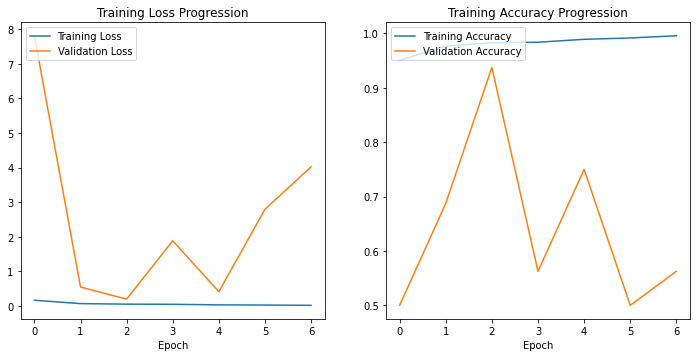

In [ ]:
plt.figure(figsize=(12, 12))
plt.subplot(2, 2, 1)
plt.plot(densenet_model.history['loss'], label='Training Loss')
plt.plot(densenet_model.history['val_loss'], label='Validation Loss')
plt.title('Training Loss Progression')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.subplot(2, 2, 2)
plt.plot(densenet_model.history['accuracy'], label='Training Accuracy')
plt.plot(densenet_model.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training Accuracy Progression')
plt.xlabel('Epoch')
plt.legend(loc='upper left')


In [ ]:
pred_densenet = densenet.predict(test_data)

In [ ]:
df_predict_dense = pd.DataFrame(pred_densenet)
df_predict_dense["file"] = test_data.filenames
df_predict_dense[1] = (df_predict_dense[1]-df_predict_dense[1].mean()) + 0.5
df_predict_dense["true_value"] = (df_predict_dense["file"].str.contains("PNEUMONIA")).apply(int)
df_predict_dense['predict_value'] = (df_predict_dense[1]>0.5).apply(int)
df_predict_dense

,0,1,file,true_value,predict_value
0,1.315929e-03,0.842133,NORMAL/IM-0001-0001.jpeg,0,1
1,4.916056e-02,0.646306,NORMAL/IM-0003-0001.jpeg,0,1
2,6.231997e-04,0.844968,NORMAL/IM-0005-0001.jpeg,0,1
3,2.550041e-02,0.743146,NORMAL/IM-0006-0001.jpeg,0,1
4,3.232148e-03,0.834290,NORMAL/IM-0007-0001.jpeg,0,1
...,...,...,...,...,...
619,8.034466e-06,0.847486,PNEUMONIA/person96_bacteria_465.jpeg,1,1
620,6.998955e-05,0.847232,PNEUMONIA/person96_bacteria_466.jpeg,1,1
621,1.031864e-05,0.847476,PNEUMONIA/person97_bacteria_468.jpeg,1,1
622,1.894983e-07,0.847518,PNEUMONIA/person99_bacteria_473.jpeg,1,1


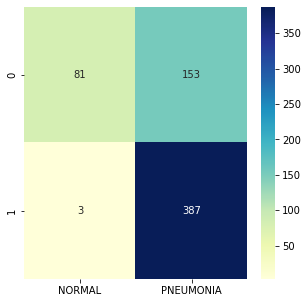

In [ ]:
confusion_matrix_cnn = pd.DataFrame(confusion_matrix(df_predict_dense["true_value"], df_predict_dense['predict_value']), columns = ['NORMAL', 'PNEUMONIA'])
plt.subplots(figsize=(5,5))
ax = sns.heatmap(confusion_matrix_cnn,  annot=True,  fmt="d", cmap="YlGnBu")

Text(0.5, 1.0, 'ROC Curve (auc = 0.897)')

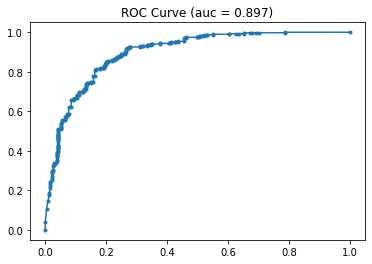

In [ ]:
dn_fpr, dn_tpr, dn_threshold = roc_curve(df_predict_dense["true_value"], df_predict_dense[1])
auc_dn = auc(dn_fpr, dn_tpr)
plt.plot(dn_fpr, dn_tpr, marker='.')
plt.title(label='ROC Curve (auc = %0.3f)' % auc_dn)

In [ ]:
print("AUC is: ", auc_dn)
print("F1 Weighted Score is: ", f1_score(df_predict_dense["true_value"], df_predict_dense['predict_value'], average = "weighted"))

AUC is:  0.8968387026079335
F1 Weighted Score is:  0.7111990261716372


In [ ]:
dn_test_accuracy = (df_predict_dense['true_value']==df_predict_dense['predict_value']).astype(int).mean()
dn_test_accuracy

0.75

**Deliverable 2**

Link to MEDIUM article: https://medium.com/@datascientist98/detecting-the-presence-of-pneumonia-using-machine-learning-26c2161448a7